In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 10,8
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from numpy.random import seed
#from tensorflow import set_random_seed

#Loading and Visualizing data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/titanic (1).csv')

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We need to convert all categorical variables into numeric format. The categorical variables we will be keeping are Embarked, Sex and Title.

The Sex variable can be encoded into single 1-or-0 column, but the other variables will need to be one-hot encoded. Regular label encoding assigns some category labels higher numerical values. This implies some sort of scale (Embarked = 1 is not more than Embarked = 0 - it's just different). One Hot Encoding avoids this problem.

We will assume that there is some ordinality in the Pclass variable, so we will leave that as a single column.

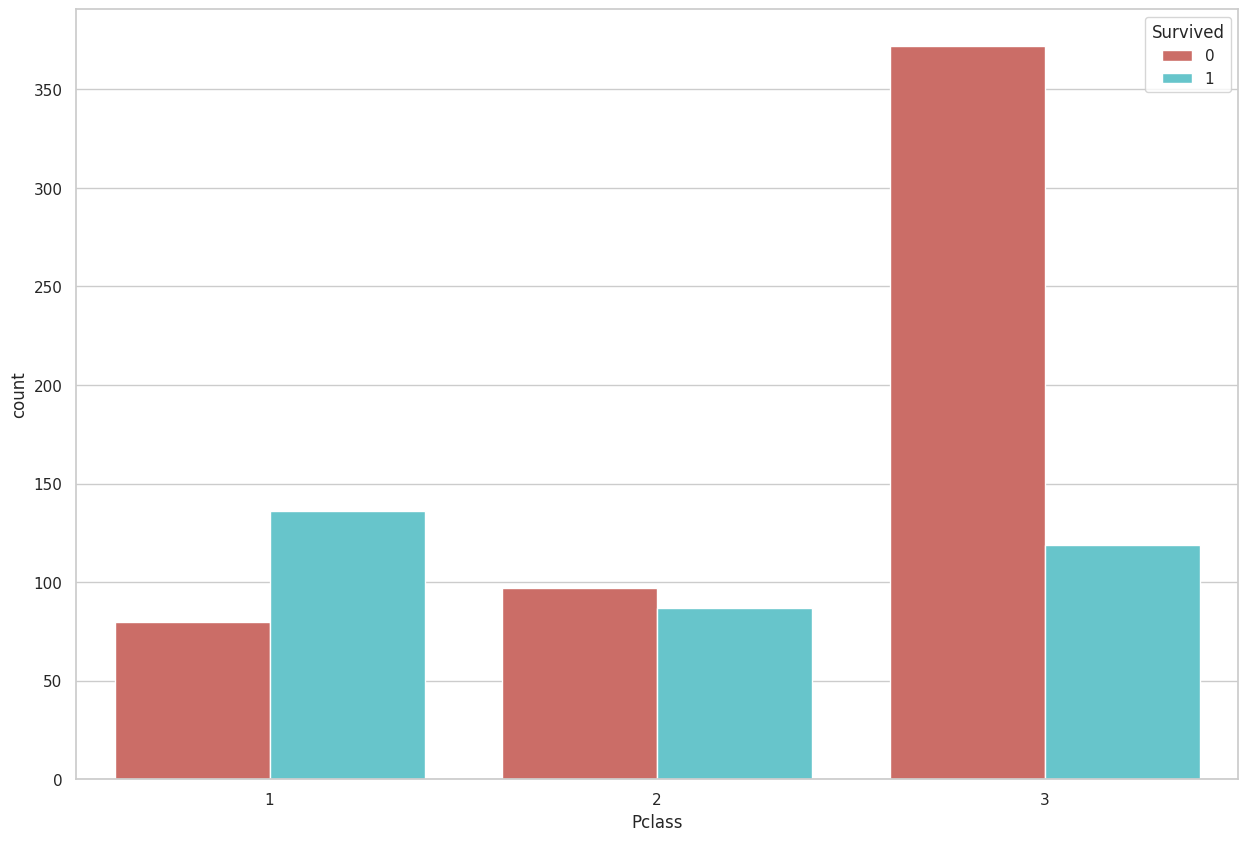

In [6]:
sns.countplot(x='Pclass', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=0)
plt.show()

* Observationally, individuals belonging to Pclass = 3 exhibit a higher likelihood of not surviving.

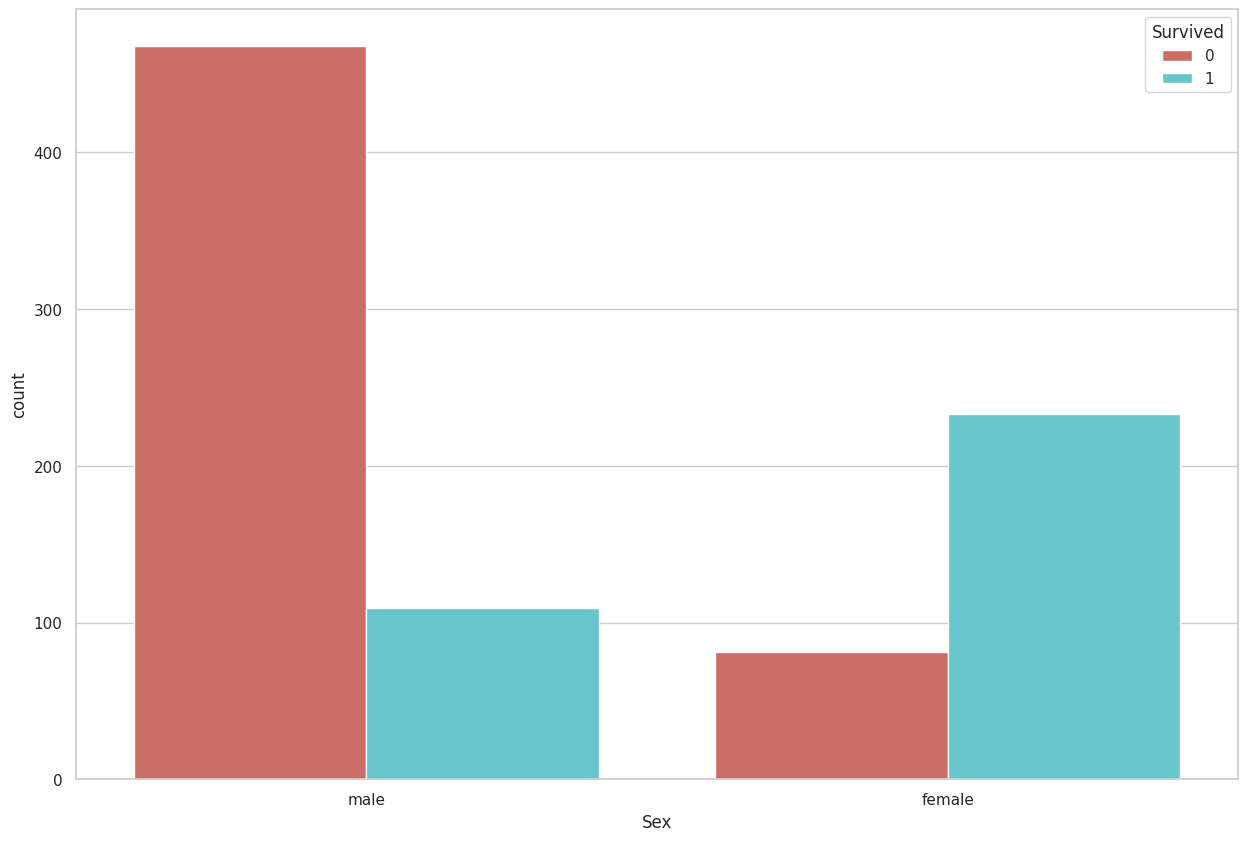

In [7]:
sns.countplot(x='Sex', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=0)
plt.show()

* It appears that males have a higher probability of not surviving.

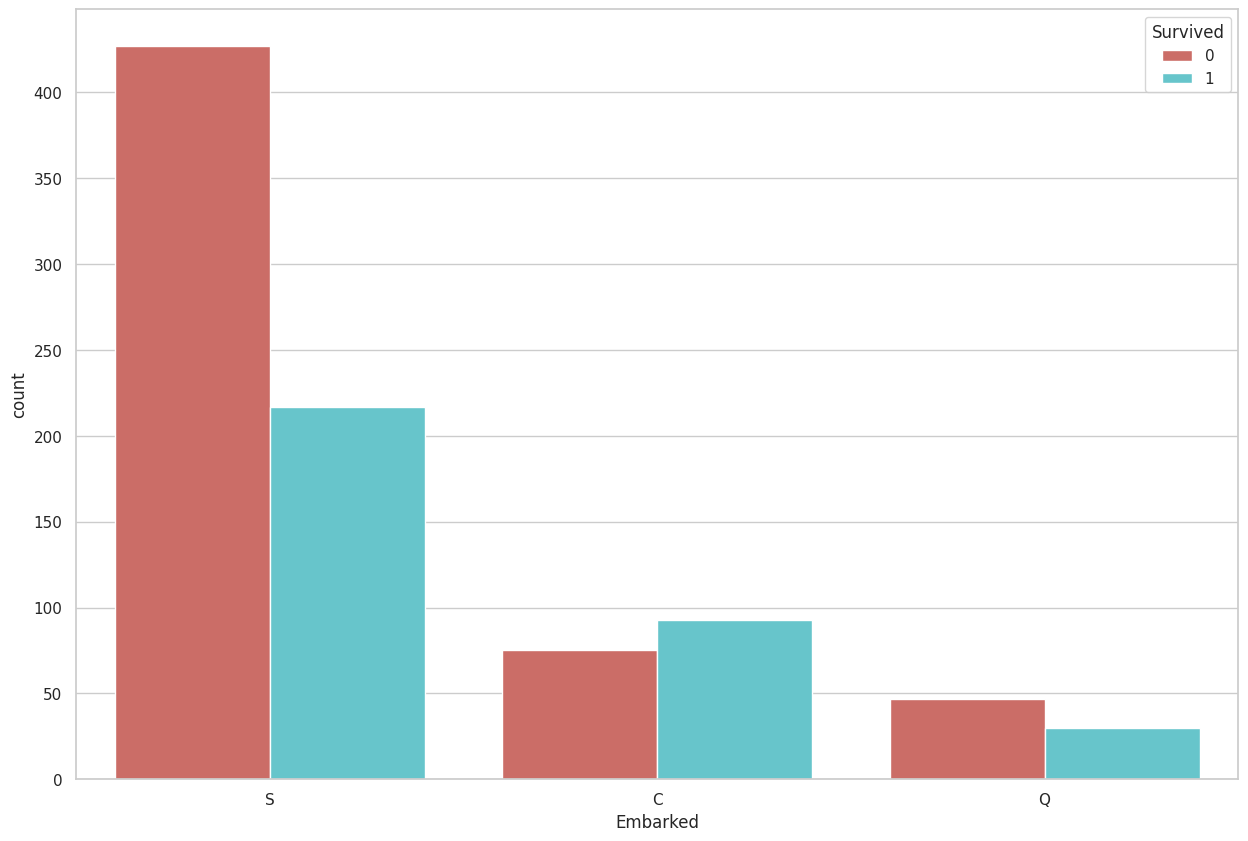

In [8]:
sns.countplot(x='Embarked', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=0)
plt.show()

* Observationally, individuals belonging to Embarked = S exhibit a higher likelihood of not surviving.

# Preprocessing data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
# convert to cateogry dtype
df['Sex'] = df['Sex'].astype('category')
# convert to category codes
df['Sex'] = df['Sex'].cat.codes

In [11]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### I will drop all features who doesn't affect to our model such as 'Cabin', 'Name', 'Ticket' and 'PassengerId'. Also, 'Cabin' has a lot of missed values, which could negatively affect to the result of our model and dropping it will reduce such problem a lot.

In [12]:
df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [13]:
df['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [14]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

Let's fill 'Age' and 'Embarked' with mean most_frequent values

In [15]:
from sklearn.impute import SimpleImputer

columns_with_nan = ["Age", "Embarked"]
imputer = SimpleImputer(strategy='most_frequent')
# Apply the imputer
# TODO Write your code here
df[columns_with_nan] = imputer.fit_transform(df[columns_with_nan])

Let's now apply one-hot encoding to the "Embarked" category.

In [16]:
df_encoded = pd.get_dummies(df, columns=['Embarked'])
df_encoded

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,False,False,True
1,1,1,0,38.0,1,0,71.2833,True,False,False
2,1,3,0,26.0,0,0,7.9250,False,False,True
3,1,1,0,35.0,1,0,53.1000,False,False,True
4,0,3,1,35.0,0,0,8.0500,False,False,True
...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,False,False,True
887,1,1,0,19.0,0,0,30.0000,False,False,True
888,0,3,0,24.0,1,2,23.4500,False,False,True
889,1,1,1,26.0,0,0,30.0000,True,False,False


In [17]:
#checking for missing values
df_encoded.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [18]:
X = df_encoded.drop(columns = 'Survived')
y = df_encoded['Survived']

Let's scale our data using MinMaxScaler

In [19]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# Define a scaler instance from one of the above
scaler = MinMaxScaler()

# Apply the scaler on both train and test features
X_preprocessed = scaler.fit_transform(X)

Split data to test and train

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
import tensorflow as tf
model = tf.keras.Sequential()

# layers
model.add(Dense(9, kernel_initializer = 'uniform', activation = 'relu', input_dim = 9))
model.add(Dense(9, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(4, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 90        
                                                                 
 dense_1 (Dense)             (None, 9)                 90        
                                                                 
 dense_2 (Dense)             (None, 4)                 40        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 225 (900.00 Byte)
Trainable params: 225 (900.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
X_numpy_train = X_train.values
y_numpy_train = y_train.values

In [23]:
X_tensor_train = tf.constant(X_numpy_train, dtype=tf.float32)
y_tensor_train = tf.constant(y_numpy_train, dtype=tf.float32)

In [36]:
import time
# Compiling the NN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the NN
t1 = time.time()
model.fit(X_tensor_train, y_tensor_train, batch_size = 32, epochs = 2000)
print('time', time.time() - t1)

Epoch 1/2000
23/23 [==============================] - 1s 2ms/step - loss: 0.4110 - accuracy: 0.8244
Epoch 2/2000
23/23 [==============================] - 0s 2ms/step - loss: 0.3966 - accuracy: 0.8315
Epoch 3/2000
23/23 [==============================] - 0s 2ms/step - loss: 0.3989 - accuracy: 0.8315
Epoch 4/2000
23/23 [==============================] - 0s 2ms/step - loss: 0.4037 - accuracy: 0.8244
Epoch 5/2000
23/23 [==============================] - 0s 2ms/step - loss: 0.4040 - accuracy: 0.8202
Epoch 6/2000
23/23 [==============================] - 0s 2ms/step - loss: 0.4000 - accuracy: 0.8301
Epoch 7/2000
23/23 [==============================] - 0s 2ms/step - loss: 0.4004 - accuracy: 0.8399
Epoch 8/2000
23/23 [==============================] - 0s 2ms/step - loss: 0.4082 - accuracy: 0.8216
Epoch 9/2000
23/23 [==============================] - 0s 2ms/step - loss: 0.4056 - accuracy: 0.8272
Epoch 10/2000
23/23 [==============================] - 0s 2ms/step - loss: 0.3974 - accuracy: 0.8315

In [37]:
# Accuracy on train data
print('accuracy on train data', model.evaluate(X_tensor_train, y_tensor_train))

23/23 [==============================] - 0s 2ms/step - loss: 0.3859 - accuracy: 0.8230
accuracy on train data [0.38593608140945435, 0.8230336904525757]


In [38]:
X_numpy_test = X_test.values
y_numpy_test = y_test.values
X_tensor_test = tf.constant(X_numpy_test, dtype=tf.float32)
y_tensor_test = tf.constant(y_numpy_test, dtype=tf.float32)
# Accuracy on test data

print('accuracy on test data', model.evaluate(X_tensor_test, y_tensor_test))

6/6 [==============================] - 0s 3ms/step - loss: 0.4541 - accuracy: 0.7542
accuracy on test data [0.4541023373603821, 0.7541899681091309]


* Notice that the model is overfitted a bit, because accuracy on test set significantly lower that in train.

#Let's train our data using Logistic regression model

In [27]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score
model2 = LogisticRegression()
model2.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [28]:
y_pred = model2.predict(X_test)
print('accuracy on test data', accuracy_score(y_test, y_pred))
print('accuracy on train data', accuracy_score(y_train, model2.predict(X_train)))

accuracy on test data 0.8100558659217877
accuracy on train data 0.8047752808988764


* In Logistic Regression model also there is no overfitting and no underfitting, the accuracy in test data is about 80% which is not bad.

# Let's train our data using Decision Tree algorithm

In [29]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [30]:
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(accuracy_score(y_train, clf.predict(X_train)))


0.7653631284916201
0.9789325842696629


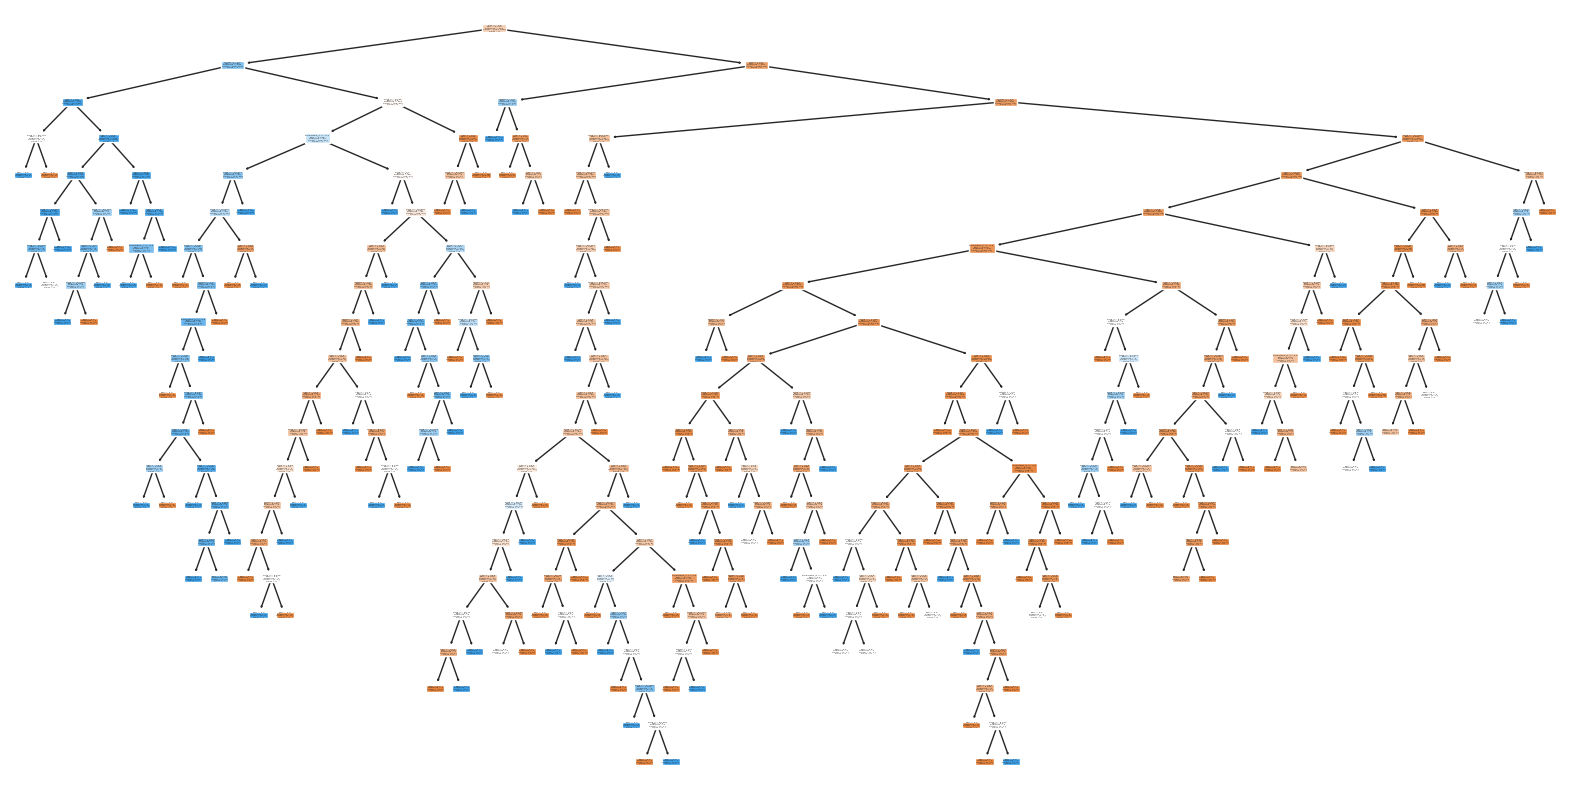

In [31]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=X_train.columns, class_names=['0', '1'], filled=True)
plt.show()

* As we can see, there is significant overfitting. However, we can address it by imposing restrictions on the depth of the tree.

* Let's do that

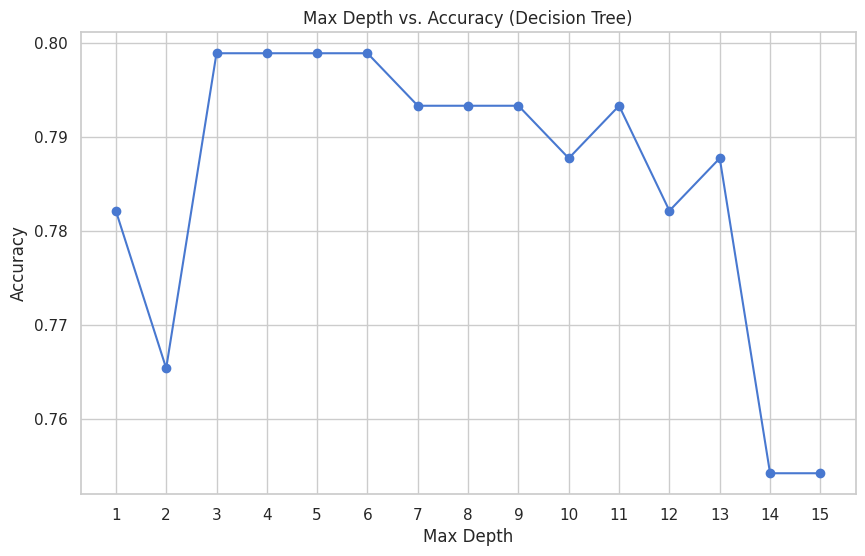

In [32]:
max_depths = range(1, 16)

accuracies = []

for max_depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(max_depths, accuracies, marker='o')
plt.title('Max Depth vs. Accuracy (Decision Tree)')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(max_depths)
plt.grid(True)
plt.show()

In [33]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth = 5)
clf = clf.fit(X_train, y_train)
print('accuracy for train data',  accuracy_score(y_train, clf.predict(X_train)))
print('accuracy for test data',  accuracy_score(y_test, clf.predict(X_test)))

accuracy for train data 0.8497191011235955
accuracy for test data 0.7988826815642458


* Wow, we could improve accuracy on test data to 80%.

#Let's train our data using Random Forest algorithm

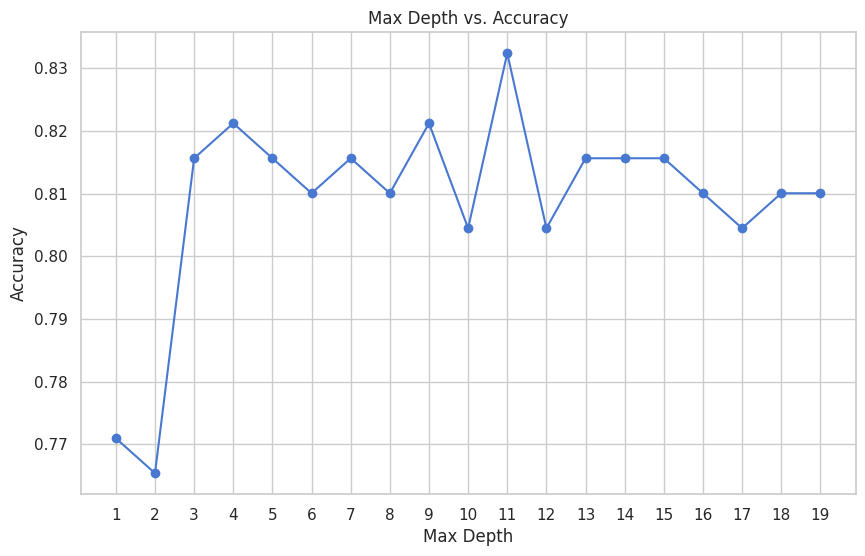

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

max_depths = range(1, 20)

accuracies = []

for max_depth in max_depths:
    random_forest = RandomForestClassifier(n_estimators=150, max_depth=max_depth, random_state=42)
    random_forest.fit(X_train, y_train)

    y_pred = random_forest.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(max_depths, accuracies, marker='o')
plt.title('Max Depth vs. Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(max_depths)
plt.grid(True)
plt.show()


* As we see for max_depth = 11 accuracy on test data is the highest. So I will choose it as a hyperparameter

In [35]:
random_forest = RandomForestClassifier(n_estimators=150, max_depth=11, random_state=42)
random_forest.fit(X_train, y_train)
print('accuracy for train data',  accuracy_score(y_train, random_forest.predict(X_train)))
print('accuracy for test data',  accuracy_score(y_test, random_forest.predict(X_test)))

accuracy for train data 0.9564606741573034
accuracy for test data 0.8324022346368715


Overall, as we see random forest solves this problem better than other models! But it's still overfitted.